In [1]:
DEBUG = True
N_DEBUG = 20

In [2]:
import pandas as pd
import numpy as np
import transformers
import torch
import re
from tqdm import tqdm
import sklearn
import spacy
nlp = spacy.load("en_core_web_sm")

In [3]:
test = pd.read_pickle("./dataset_test.pkl")


documents = test["answer"]
gold_labels = test["author"] == "human_answers" # convention: 0: machine, 1: human, see detector.py

if DEBUG and N_DEBUG > 0:
    documents = documents[0:N_DEBUG]
    gold_labels = gold_labels[0:N_DEBUG]



#from gpt2outputdataset.detector_radford import DetectorRadford
#from detectgpt.detector_detectgpt import DetectorDetectGPT
from detector_guo import DetectorGuo
detector_classes = [DetectorGuo]#,DetectorRadford,DetectorDetectGPT]

from explainer_wrappers import LIME_Explainer, SHAP_Explainer
explainer_classes = [LIME_Explainer,SHAP_Explainer]

In [4]:
detector = DetectorGuo()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:
explainer = SHAP_Explainer(detector)

In [6]:
gold_labels.iloc[2]

False

In [7]:
document = documents.iloc[2]

In [8]:
    # n_to_remove = 5
    # include_zero_scores = False

In [9]:

# highest_fi_scores_machine = sorted(fi_scores_machine, key=lambda x: x[1], reverse=True)[0:n_to_remove]
# if not include_zero_scores:
#     highest_fi_scores_machine = [(idx, fi) for idx,fi in highest_fi_scores_machine if fi != 0]
# highest_fi_scores_machine

In [10]:
# lowest_fi_scores_machine = sorted(fi_scores_machine, key=lambda x: x[1], reverse=False)[0:n_to_remove]
# if not include_zero_scores:
#     lowest_fi_scores_machine = [(idx, fi) for idx, fi in lowest_fi_scores_machine if fi != 0]
# lowest_fi_scores_machine

In [11]:
from abc import ABC, abstractmethod
class Experiment(ABC):
    @abstractmethod 
    def __init__(self, explainer, document, gt):
        self.document = document
        self.gt = gt
        self.explainer = explainer
        self.fi_scores_machine  = self.explainer.get_fi_scores(document, fill=True)[0]
        self.fi_scores_human = self.explainer.get_fi_scores(document, fill=True)[1]
    @property
    @abstractmethod
    def modified_document(self):
        pass
    def get_fi_scores_target(self):
        if self.gt:
            return self.fi_scores_human
        else:
            return self.fi_scores_machine
    def remove_features(self, id_fi_tuples_list, mask=True):
        tokenized_modified_document = self.explainer.tokenize(self.document)

        # two asserts to verify that approach is valid
       # print("r",expself.explainerlainer.untokenize(self.explainer.tokenize(self.document, collapse_whitespace=False)))
       # print("o", self.document)
        # this fails: 
        # assert self.explainer.untokenize(self.explainer.tokenize(self.document, collapse_whitespace=False)) == self.document, "Merging strategy faulty"
        # see self.explainer.LIME_Explainer.untokenize
       
        ### assert right words are removed
        top_words = [word for word, fi in self.explainer.as_list(self.explainer.get_explanation_cached(self.document), label=self.gt) if fi > 0]
        for a, b in zip(tokenized_modified_document, self.explainer.tokenize(self.document)):
            if a == self.explainer.detector.get_pad_token():
                assert b in top_words, "Masking strategy faulty"
        ###
       
        ids_tokens_to_remove = []
        # don't remove anything if there are no best/worst features (e.g. only positive or only negative fi scores)
        if len(id_fi_tuples_list):
            ids_tokens_to_remove, _ = zip(*id_fi_tuples_list) 
        # replace with pad token (all detectors support partial input)
        if mask:
            for t in ids_tokens_to_remove:
                tokenized_modified_document[t] = self.explainer.detector.get_pad_token()
        else:
            tokenized_modified_document = [t for i, t in enumerate(tokenized_modified_document) if i not in ids_tokens_to_remove]
        return self.explainer.untokenize(tokenized_modified_document)

In [12]:
class Experiment_Delete_n_Highest(Experiment):
    def __init__(self, explainer, document, gt, include_zero_scores=False, n=10, mask=True):
        super().__init__(explainer, document, gt)
        self.n = n
        self.include_zero_scores = include_zero_scores
        self.mask = mask
    @property
    def modified_document(self):
        highest_fi_scores_target = sorted(self.get_fi_scores_target(), key=lambda x: x[1], reverse=True)[0:self.n]
        # remove 0 scores if !include_zero_scores
        highest_fi_scores_target = [(idx, fi) for idx,fi in highest_fi_scores_target if self.include_zero_scores or (fi != 0)]
        return self.remove_features(highest_fi_scores_target, mask=self.mask)


In [13]:
class Experiment_Delete_n_Lowest(Experiment):
    def __init__(self, explainer, document, gt, include_zero_scores=False, n=10, mask=True):
        super().__init__(explainer, document, gt)
        self.n = n
        self.include_zero_scores = include_zero_scores
        self.mask = mask
    @property
    def modified_document(self):
        lowest_fi_scores_target = sorted(self.get_fi_scores_target(), key=lambda x: x[1], reverse=False)[0:self.n]
        # remove 0 scores if !include_zero_scores
        lowest_fi_scores_target = [(idx, fi) for idx,fi in lowest_fi_scores_target if self.include_zero_scores or (fi != 0)]
        return self.remove_features(lowest_fi_scores_target, mask=self.mask)


In [14]:
class Experiment_Delete_all_except_n_Highest(Experiment):
    def __init__(self, explainer, document, gt, include_zero_scores=False, n=10, mask=True):
        super().__init__(explainer, document, gt)
        self.n = n
        self.include_zero_scores = include_zero_scores
        self.mask = mask
    @property
    def modified_document(self):
        all_but_highest_fi_scores_target = sorted(self.get_fi_scores_target(), key=lambda x: x[1], reverse=True)[self.n:]
        all_but_highest_fi_scores_target = [(idx, fi) for idx,fi in all_but_highest_fi_scores_target if self.include_zero_scores or (fi != 0)]
        return self.remove_features(all_but_highest_fi_scores_target, mask=self.mask)

In [15]:
class Experiment_Delete_all_except_n_Lowest(Experiment):
    def __init__(self, explainer, document, gt, include_zero_scores=False, n=10, mask=True):
        super().__init__(explainer, document, gt)
        self.n = n
        self.include_zero_scores = include_zero_scores
        self.mask = mask
    @property
    def modified_document(self):

        all_but_lowest_fi_scores_target = sorted(self.get_fi_scores_target(), key=lambda x: x[1], reverse=False)[self.n:]
        all_but_lowest_fi_scores_target = [(idx, fi) for idx,fi in all_but_lowest_fi_scores_target if self.include_zero_scores or (fi != 0)]
        return self.remove_features(all_but_lowest_fi_scores_target, mask=self.mask)

In [16]:
def run_experiment(experiment_class, n=10):
    predictions = []
    for explainer_class in explainer_classes:
        explainer = explainer_class(detector)
        for document, gt in zip(documents, gold_labels):
            experiment = experiment_class(explainer, document, gt, n=n)
        #    print(experiment.document)
         #   print(experiment.modified_document)
          #  print("-----------")
            p = detector.predict_proba([experiment.document, experiment.modified_document])

            p_machine_original = p[0,0]
            p_human_original = p[0,1]

            p_machine_modified = p[1,0]
            p_human_modified = p[1,1]
            predictions.append((
                            explainer.__class__.__name__, 
                            explainer.detector.__class__.__name__, 
                            n,
                            p_machine_original,
                            p_human_original,
                            p_machine_modified,
                            p_human_modified,
                            gt))
    df = pd.DataFrame(predictions, columns=["Explainer", "Detector", "n", "p_machine_original", "p_human_original", "p_machine_modified", "p_human_modified", "gt"])

    df["p_target_original"] = df.apply(lambda x: x["p_human_original"] if x["gt"] else x["p_machine_original"], axis=1)
    df["p_target_modified"] = df.apply(lambda x: x["p_human_modified"] if x["gt"] else x["p_machine_modified"], axis=1)     
    return df

In [17]:
import matplotlib.pyplot as plt

In [18]:
def run_experiment_incremental(experiment_class, start = 0, stop = 5):
    dfs = [run_experiment(experiment_class, n=n) for n in tqdm(range(start,stop+1))]
    df = pd.concat(dfs)
    df["drop_target"] = df["p_target_original"] - df["p_target_modified"]

    for name, group in df.groupby(["Explainer", "Detector", ]):
        print(name)
        group.reset_index()[["n", "drop_target"]].groupby("n").mean().plot()
        plt.show()

    

In [19]:
# # Experiment_Delete_n_Highest: higher drop_target is better
# df = run_experiment(Experiment_Delete_n_Highest)
# df["drop_target"] = df["p_target_original"] - df["p_target_modified"]
# df.groupby(["Explainer", "Detector"]).mean()

100%|██████████| 6/6 [00:14<00:00,  2.39s/it]

('LIME_Explainer', 'DetectorGuo')


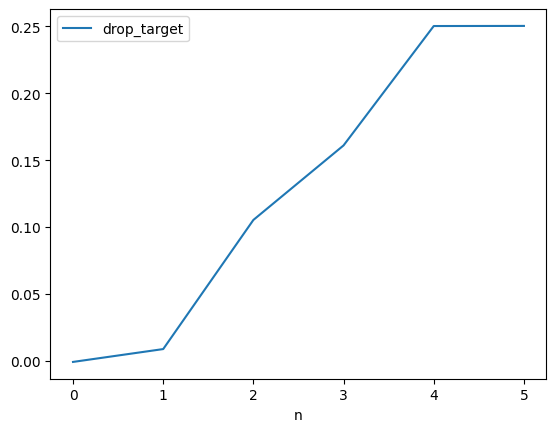

('SHAP_Explainer', 'DetectorGuo')


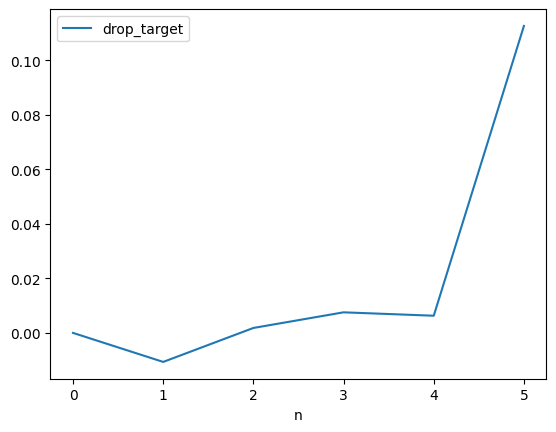

In [20]:
# Experiment_Delete_n_Highest: higher drop_target is better

run_experiment_incremental(Experiment_Delete_n_Highest)


In [ ]:
# Experiment_Delete_n_Lowest: smaller drop_target is better
run_experiment_incremental(Experiment_Delete_n_Lowest)


In [ ]:
# Experiment_Delete_all_except_n_Highest: smaller drop_target is better
run_experiment_incremental(Experiment_Delete_all_except_n_Highest)


In [ ]:
# Experiment_Delete_all_except_n_Lowest: higher drop_target is better
run_experiment_incremental(Experiment_Delete_all_except_n_Lowest)

In [ ]:
df